In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.regularizers import l2



/Users/user/repos/tbilisi_home_price_prediction_model/pricing_model/env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
%matplotlib inline


In [3]:
path_to_csv = "../data/housing_data.csv"
image_dir = "../data/images/" 
column_names = ["id", "url", "imageurl", "header", "price", "sqmprice", "sqm", "floor", "rooms", "bedrooms", "address"]


In [4]:
df = pd.read_csv(path_to_csv, names=column_names, header=None)
image_files = set(os.listdir(image_dir))
valid_ids = {int(filename.split('.')[0]) for filename in image_files if filename.split('.')[0].isdigit()}
df = df[df.iloc[:, 0].isin(valid_ids)]
df = df.dropna() # We lost 5% of the data, problem seems to be with the method of scraping or the website error itself
df.drop(['url', 'imageurl'], axis=1, inplace=True)

In [5]:
def modify_address(addr):
    # Split the address string by comma and retain everything after the first comma
    parts = addr.split(',', 1)  # Split only at the first comma
    return parts[1].strip() if len(parts) > 1 else addr

In [6]:
mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() < 30].index)

# Filter the dataframe using the mask
df.loc[mask, 'address'] = df.loc[mask, 'address'].apply(modify_address)
df['address'] = df['address'].str.replace(', ', '', regex=True)
mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() < 30].index)

df.loc[mask, 'address'] = df.loc[mask, 'address'].apply(modify_address)

mask = df["address"].isin(df["address"].value_counts()[df["address"].value_counts() > 40].index)

df = df[mask]

In [7]:
df['address'] = df['address'].str.replace(', ', '', regex=True)

In [8]:
df[df['address'].str.startswith('')]

,id,header,price,sqmprice,sqm,floor,rooms,bedrooms,address
0,0,იყიდება ახალი აშენებული ბინა მთაწმინდაზე,"210,000",3134.0,67.00 მ²,სარ. 5,ოთ. 3,საძ. 2,მთაწმინდამთაწმინდის რაიონითბილისი
1,1,იყიდება ძველი აშენებული ბინა დიდუბეში,"185,000",1595.0,116.00 მ²,სარ. 4,ოთ. 5,საძ. 4,ა. წერეთლის გამზირიდიდუბედიდუბის რაიონითბილისი
3,3,იყიდება ახალი აშენებული ბინა ორთაჭალაში,"138,000",1917.0,72.00 მ²,სარ. 7,ოთ. 3,საძ. 2,ვ. გორგასლის ქუჩაორთაჭალაკრწანისის რაიონითბილისი
5,5,იყიდება ახალი აშენებული ბინა დიდ დიღომში,"60,000",1200.0,50.00 მ²,სარ. 2,ოთ. 2,საძ. 1,დიდი დიღომისაბურთალოს რაიონითბილისი
6,6,იყიდება ძველი აშენებული ბინა ვაზისუბანში,"55,000",833.0,66.00 მ²,სარ. 5,ოთ. 3,საძ. 2,შ. პეტეფის ქუჩავაზისუბანიისნის რაიონითბილისი
...,...,...,...,...,...,...,...,...,...
63091,63093,იყიდება ახალი აშენებული ბინა ვარკეთილის მასივი...,"78,000",975.0,80.00 მ²,სარ. 6,ოთ. 3,საძ. 2,ვარკეთილის მასივი IIIვარკეთილი-3 III მ/რვარკეთ...
63092,63094,იყიდება ახალი აშენებული ბინა საბურთალოზე,"180,000",1385.0,130.00 მ²,სარ. 7,ოთ. 4,საძ. 3,ს. ჩიქოვანის ქუჩასაბურთალოსაბურთალოს რაიონითბი...
63093,63095,იყიდება ახალი აშენებული ბინა საბურთალოზე,"89,000",1935.0,46.00 მ²,სარ. 17,ოთ. 2,საძ. 1,ბერბუკის ქუჩასაბურთალოსაბურთალოს რაიონითბილისი
63094,63096,იყიდება ახალი აშენებული ბინა ნაძალადევში,"85,000",1700.0,50.00 მ²,სარ. 2,ოთ. 2,საძ. 1,ც. დადიანის ქუჩანაძალადევინაძალადევის რაიონითბ...


In [9]:
df["address"].value_counts()

address
დიდი დიღომისაბურთალოს რაიონითბილისი                                             1830
ა. პოლიტკოვსკაიას ქუჩა (ჯიქია)საბურთალოსაბურთალოს რაიონითბილისი                 1707
საბურთალოსაბურთალოს რაიონითბილისი                                               1668
ი. ჭავჭავაძის გამზირივაკევაკის რაიონითბილისი                                    1206
ვაკევაკის რაიონითბილისი                                                          964
                                                                                ... 
როსტევანის ქუჩადიდი დიღომისაბურთალოს რაიონითბილისი                                42
ი. მოსაშვილის ქუჩავაკევაკის რაიონითბილისი                                         42
ვაჟა-ფშაველას I კვ.ვაჟა-ფშაველას კვარტალებისაბურთალოსაბურთალოს რაიონითბილისი      42
ლიბანის ქუჩაავჭალაგლდანის რაიონითბილისი                                           41
მ. ბუხაიძის ქუჩავორონცოვიჩუღურეთის რაიონითბილისი                                  41
Name: count, Length: 269, dtype: int64

In [10]:
before_scaling_df = df

In [11]:
df['status'] = df['header'].str.split().str.get(1)
df['location_name'] = df['header'].str.replace("იყიდება ახალი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება ძველი აშენებული ბინა ", "", regex=False).str.strip()
df['location_name'] = df['location_name'].str.replace("იყიდება მშენებარე ბინა ", "", regex=False).str.strip()

value_counts = df['location_name'].value_counts()
print(value_counts)
# Keep only rows where the 'location_name' value count is >= 30
df = df[df['location_name'].isin(value_counts[value_counts >= 30].index)]
df.drop(['header'], axis=1, inplace=True)


location_name
საბურთალოზე        11556
ვაკეში              4827
დიდ დიღომში         3381
დიდუბეში            2386
გლდანის მასივში     2247
                   ...  
ფონიჭალაში             1
ივერთუბანში            1
ლოტკინზე               1
ორხევში                1
ახალდაბაში             1
Name: count, Length: 109, dtype: int64


/var/folders/5n/v4r1bflj5gd3ry2xml0qlzsh0000gp/T/ipykernel_82719/3830233740.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['header'], axis=1, inplace=True)


In [12]:
df["price"] = df["price"].str.replace(",", "").astype(float)
df["sqm"] = df["sqm"].str.replace(" მ²", "").astype(float)
df["floor"] = df["floor"].str.replace("სარ.", "").astype(float)
df["rooms"] = df["rooms"].str.replace("ოთ.", "").astype(float)
df["bedrooms"] = df["bedrooms"].str.replace("საძ.", "").astype(float)
df.drop("sqmprice", axis=1, inplace=True)
df.drop("id", axis=1, inplace=True)



/var/folders/5n/v4r1bflj5gd3ry2xml0qlzsh0000gp/T/ipykernel_82719/3070115346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["price"] = df["price"].str.replace(",", "").astype(float)
/var/folders/5n/v4r1bflj5gd3ry2xml0qlzsh0000gp/T/ipykernel_82719/3070115346.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sqm"] = df["sqm"].str.replace(" მ²", "").astype(float)
/var/folders/5n/v4r1bflj5gd3ry2xml0qlzsh0000gp/T/ipykernel_82719/3070115346.py:3: SettingWithCopyWarning: 
A value is trying to be set o

In [13]:
df.sort_values(by='price', ascending=True)

,price,sqm,floor,rooms,bedrooms,address,status,location_name
12625,12800.0,44.9,12.0,2.0,1.0,მირიან მეფის ქუჩადიდი დიღომისაბურთალოს რაიონით...,მშენებარე,დიდ დიღომში
22055,13000.0,13.0,1.0,1.0,1.0,ვაჟა-ფშაველას კვარტალებისაბურთალოსაბურთალოს რა...,ახალი,ვაჟა-ფშაველას კვარტალებში
40403,14000.0,34.0,1.0,3.0,1.0,გლდანი 1 მკრ.გლდანის მასივიგლდანის რაიონითბილისი,ახალი,გლდანი 1 მკრ. რაიონში
52772,14500.0,43.2,2.0,2.0,1.0,მირიან მეფის ქუჩადიდი დიღომისაბურთალოს რაიონით...,მშენებარე,დიდ დიღომში
16714,15000.0,8.9,1.0,1.0,1.0,სოლოლაკიმთაწმინდის რაიონითბილისი,ძველი,სოლოლაკში
...,...,...,...,...,...,...,...,...
16671,13950000.0,90.0,1.0,3.0,2.0,საბურთალოსაბურთალოს რაიონითბილისი,ახალი,საბურთალოზე
3467,16200000.0,108.0,2.0,3.0,2.0,ა. პოლიტკოვსკაიას ქუჩა (ჯიქია)საბურთალოსაბურთა...,ახალი,საბურთალოზე
18797,32400000.0,120.0,4.0,3.0,2.0,ვაკევაკის რაიონითბილისი,ახალი,ვაკეში
15287,100000000.0,251.0,2.0,7.0,5.0,ვერამთაწმინდის რაიონითბილისი,ძველი,ვერაზე


In [14]:
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
print(f"Number of jpg images in {image_dir}: {len(image_files)}")


Number of jpg images in ../data/images/: 57837


In [15]:
df = df[df["price"] <= 500000]
df = df[df["price"] >= 10000]


In [16]:
scaler = MinMaxScaler()
price_scaler = MinMaxScaler()
df[['sqm', 'floor', 'rooms', 'bedrooms']] = scaler.fit_transform(df[['sqm', 'floor', 'rooms', 'bedrooms']])
df[['price']] = price_scaler.fit_transform(df[['price']])

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=['location_name', "status", "address"])

bool_cols = [col for col in df.columns if df[col].dtype == 'bool']
df[bool_cols] = df[bool_cols].astype(int)
# Split the data into training and test sets
y = df['price']
X = df.drop('price', axis=1)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:

# Input layer
input_layer = Input(shape=(X_train.shape[1],))

# First Dense and BatchNormalization layers
x = layers.Dense(512, kernel_initializer='he_normal')(input_layer)
x = layers.BatchNormalization()(x)
x = Activation('relu')(x)


# Second Dense and BatchNormalization layers
x = layers.Dense(256, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = Activation('relu')(x)

# Third Dense and BatchNormalization layers
x = layers.Dense(64, kernel_initializer='he_normal')(x)
x = layers.BatchNormalization()(x)
x = Activation('relu')(x)


# Fifth Dense layer

# Output layer
output_layer = layers.Dense(1, activation='linear')(x)

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)


In [18]:
model.compile(optimizer=keras.optimizers.legacy.Adam(0.001), loss='mean_squared_error',  metrics=['mean_absolute_error', "mean_absolute_percentage_error"])

In [19]:
#Train for approx 300 epochs
history = model.fit(X_train, y_train, epochs=1000, batch_size=64, validation_data=(X_dev, y_dev))

Epoch 1/1000
648/648 [==============================] - 5s 6ms/step - loss: 0.0305 - mean_absolute_error: 0.1111 - mean_absolute_percentage_error: 1117.6936 - val_loss: 0.0123 - val_mean_absolute_error: 0.0813 - val_mean_absolute_percentage_error: 45.4431
Epoch 2/1000
648/648 [==============================] - 4s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0662 - mean_absolute_percentage_error: 190.7615 - val_loss: 0.0073 - val_mean_absolute_error: 0.0594 - val_mean_absolute_percentage_error: 33.8688
Epoch 3/1000
648/648 [==============================] - 4s 6ms/step - loss: 0.0074 - mean_absolute_error: 0.0595 - mean_absolute_percentage_error: 2707.7207 - val_loss: 0.0071 - val_mean_absolute_error: 0.0562 - val_mean_absolute_percentage_error: 28.1805
Epoch 4/1000
648/648 [==============================] - 5s 8ms/step - loss: 0.0068 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 2616.3779 - val_loss: 0.0060 - val_mean_absolute_error: 0.0513 - val_mean_absolute_per

In [20]:
model.save('only_csv_model')

INFO:tensorflow:Assets written to: only_csv_model/assets


INFO:tensorflow:Assets written to: only_csv_model/assets


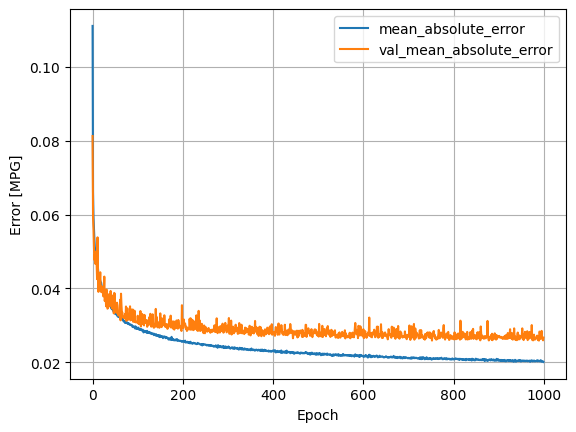

In [21]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
def plot_mae(history):
  plt.plot(history.history['mean_absolute_error'], label='mean_absolute_error')
  plt.plot(history.history['val_mean_absolute_error'], label='val_mean_absolute_error')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)  
#plot_loss(history)
plot_mae(history)

In [22]:
loss, mae, maep = model.evaluate(X_dev, y_dev)
train_loss, train_mae, train_maep = model.evaluate(X_train, y_train)

print(f"Test Loss: {loss}")
scaled_mae = mae
scaled_train_mae = train_mae
original_mae = scaled_mae * (price_scaler.data_max_ - price_scaler.data_min_)
original_train_mae = scaled_train_mae * (price_scaler.data_max_ - price_scaler.data_min_)

print(f"Original MAE: {original_mae[0]}")
print(f"Original train MAE: {original_train_mae[0]}")
print(f"Original MAPE: {maep}")
print(f"Original train MAPE: {train_maep}")

1296/1296 [==============================] - 2s 1ms/step - loss: 7.8308e-04 - mean_absolute_error: 0.0161 - mean_absolute_percentage_error: 806.0344
Test Loss: 0.002847902709618211
Original MAE: 12985.390225052834
Original train MAE: 7855.660365521908
Original MAPE: 13.47242546081543
Original train MAPE: 806.0343627929688


In [23]:
# 1. Predict on test data
y_pred = model.predict(X_dev)

# Inverse transform the scaled target variable (y_dev)
y_dev_actual = price_scaler.inverse_transform(y_dev.values.reshape(-1, 1))

# Inverse transform the scaled predictions (y_pred)
y_pred_actual = price_scaler.inverse_transform(y_pred.reshape(-1, 1))

print(y_dev_actual.shape)
print(y_pred_actual.shape)

# 2. Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Values': y_dev_actual.flatten(),
    'Predicted Values': y_pred_actual.flatten() # flatten is used to convert the 2D array to 1D
})

print(comparison_df)


162/162 [==============================] - 0s 1ms/step
(5182, 1)
(5182, 1)
      Actual Values  Predicted Values
0           39000.0      34201.679688
1           85000.0      83830.953125
2           47000.0      42153.929688
3          112000.0     102273.796875
4           85000.0      81552.976562
...             ...               ...
5177       230000.0     228852.968750
5178        76000.0      72240.484375
5179       136000.0     122234.257812
5180        68400.0      46629.183594
5181       488000.0     466387.656250

[5182 rows x 2 columns]


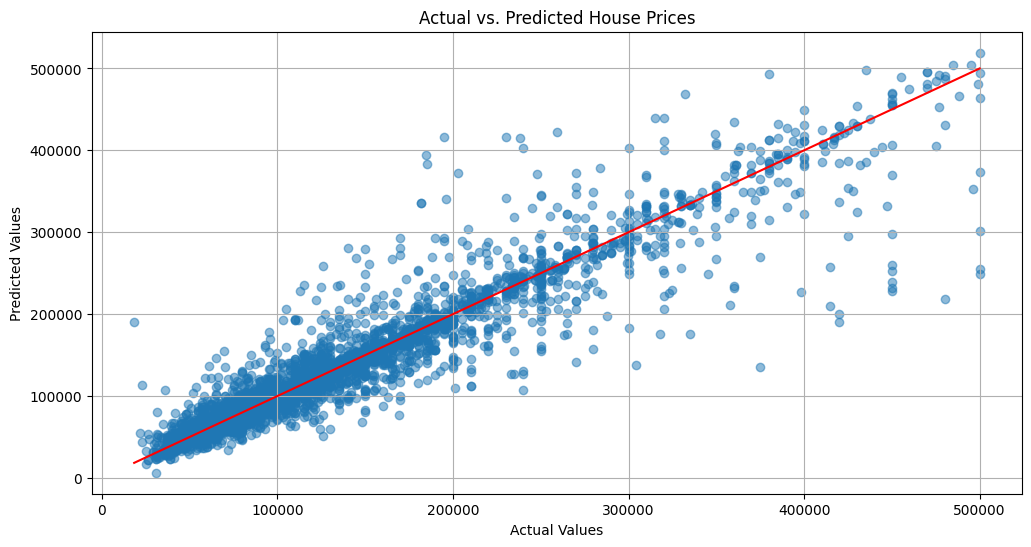

In [24]:
import matplotlib.pyplot as plt

# Scatter plot of Actual vs. Predicted values
plt.figure(figsize=(12, 6))

# Scatter plot
plt.scatter(comparison_df['Actual Values'], comparison_df['Predicted Values'], alpha=0.5)
plt.plot([min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         [min(comparison_df['Actual Values']), max(comparison_df['Actual Values'])], 
         color='red')  # Diagonal line

plt.title('Actual vs. Predicted House Prices')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [25]:
y_pred_test = model.predict(X_dev)
y_dev_actual_for_r2 = price_scaler.inverse_transform(y_dev.values.reshape(-1, 1))
y_pred_actual_for_r2 = price_scaler.inverse_transform(y_pred_test.reshape(-1, 1))

# Calculate the R^2 score
r2 = r2_score(y_dev_actual_for_r2, y_pred_actual_for_r2)
r2

162/162 [==============================] - 0s 1ms/step


0.8950211194551032

In [26]:
y_train_pred = model.predict(X_train)
# Convert predictions back to original scale
y_train_pred_original = price_scaler.inverse_transform(y_train_pred)

# Convert y_train back to original scale
y_train_original = price_scaler.inverse_transform(y_train.values.reshape(-1, 1))

# Compute the percentage error for each observation
percentage_errors = np.abs((y_train_original - y_train_pred_original) / y_train_original) * 100


1296/1296 [==============================] - 2s 1ms/step


In [27]:
# Get indices of the top outliers
sorted_indices = np.argsort(percentage_errors, axis=0)[::-1]

# For instance, to get the top 10 outliers:
top_10_outliers = sorted_indices[:10]


In [29]:
# Convert top_10_outliers to a 1D array
top_10_outliers = top_10_outliers.flatten()

# Retrieve the rows from the original dataframe corresponding to these outliers
outliers_df = before_scaling_df.iloc[top_10_outliers]
outliers_df


,id,header,price,sqmprice,sqm,floor,rooms,bedrooms,address,status,location_name
23968,23969,იყიდება ძველი აშენებული ბინა ვაჟა-ფშაველას II ...,"120,000",1043.0,115.00 მ²,სარ. 3,ოთ. 4,საძ. 2,ვაჟა-ფშაველას II კვ.ვაჟა-ფშაველას კვარტალებისა...,ძველი,ვაჟა-ფშაველას II კვარტალში
19559,19560,იყიდება ახალი აშენებული ბინა საბურთალოზე,"96,000",1655.0,58.00 მ²,სარ. 3,ოთ. 3,საძ. 2,ა. პოლიტკოვსკაიას ქუჩა (ჯიქია)საბურთალოსაბურთა...,ახალი,საბურთალოზე
14102,14103,იყიდება ძველი აშენებული ბინა საბურთალოზე,"55,000",1196.0,46.00 მ²,სარ. 3,ოთ. 2,საძ. 1,ალ. ყაზბეგის გამზირისაბურთალოსაბურთალოს რაიონი...,ძველი,საბურთალოზე
35976,35977,იყიდება ახალი აშენებული ბინა ვაკეში,"150,000",2083.0,72.00 მ²,სარ. 15,ოთ. 2,საძ. 1,ი. ჭავჭავაძის გამზირივაკევაკის რაიონითბილისი,ახალი,ვაკეში
34365,34366,იყიდება ახალი აშენებული ბინა დიღმის მასივში,"85,000",924.0,92.00 მ²,სარ. 1,ოთ. 3,საძ. 2,დიღმის მასივიდიდუბის რაიონითბილისი,ახალი,დიღმის მასივში
48469,48471,იყიდება ახალი აშენებული ბინა დოლაბაურში,"58,500",1950.0,30.00 მ²,სარ. 2,ოთ. 1,საძ. 1,ქეთევან წამებულის გამზ.დოლაბაურიისანიისნის რაი...,ახალი,დოლაბაურში
47953,47955,იყიდება ახალი აშენებული ბინა საბურთალოზე,"145,000",2302.0,63.00 მ²,სარ. 10,ოთ. 2,საძ. 1,ა. პოლიტკოვსკაიას ქუჩა (ჯიქია)საბურთალოსაბურთა...,ახალი,საბურთალოზე
43869,43870,იყიდება ახალი აშენებული ბინა ვაკეში,"230,000",2527.0,91.00 მ²,სარ. 11,ოთ. 3,საძ. 2,მ. თამარაშვილის გამზ (ვაკის მიმდ)ვაკევაკის რაი...,ახალი,ვაკეში
35796,35797,იყიდება მშენებარე ბინა ორთაჭალაში,"83,000",1235.0,67.20 მ²,სარ. 5,ოთ. 2,საძ. 1,ორთაჭალაკრწანისის რაიონითბილისი,მშენებარე,ორთაჭალაში
16657,16658,იყიდება ახალი აშენებული ბინა საბურთალოზე,"250,000",1838.0,136.00 მ²,სარ. 10,ოთ. 4,საძ. 3,პ. ქავთარაძის ქუჩასაბურთალოსაბურთალოს რაიონითბ...,ახალი,საბურთალოზე
